
#                              **PROBLEM SET 3 - MACHINE LEARNING IN STATISTICS** 

### My Understanding of the Assignment

To do this assignment, I follow the steps below: 
1) Set up and import libraries 
2) Load the California housing data.
3) Split into training and testing sets using income categories to keep both sets balanced.
4) Preprocess the data (handle missing values, scale numeric data, encode text). [this is where I use ChatGPT]
5) Train a Gradient Boosting Regressor on the training data 
6) Use Grid Search to find the best combination of how many trees (n_estimators) and how big each learning step should be (learning_rate).
7) Check model accuracy on the testing set (by computing RMSE — root mean squared error).

For (4) and (5), I have used the codes shared by the professor in the question of this homework assignment. 

### Step 1: Set up

In [11]:
# Python 3.7 or above:

import sys

assert sys.version_info >= (3, 7)

# Get Scikit-Learn ≥ 1.0.1:

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import pandas as pd
import tarfile 
import urllib.request
import io

### Step 2: Get the data and take a look 

In [12]:
def load_housing_data():
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    response = urllib.request.urlopen(url)
    file_like_object = io.BytesIO(response.read())
    with tarfile.open(fileobj = file_like_object) as housing_tarball:
        csv_file = housing_tarball.extractfile("housing/housing.csv")
        csv_data = io.BytesIO(csv_file.read())
    return pd.read_csv(csv_data)

#store the housing dataset in the variable 'housing'
housing = load_housing_data()

In [13]:
housing.head(15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [14]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [15]:
housing ["median_income"].value_counts()

median_income
3.1250     49
15.0001    49
2.8750     46
4.1250     44
2.6250     44
           ..
4.2670      1
2.1217      1
4.9706      1
3.4450      1
2.0943      1
Name: count, Length: 12928, dtype: int64

### Step 3: Create an income category, stratify the sample and split into training and testing samples

In [18]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

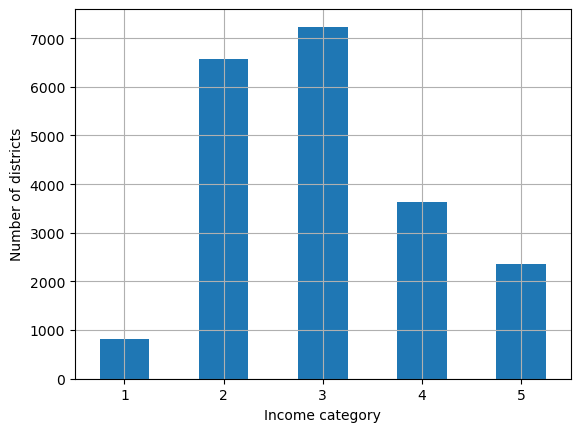

In [21]:
import matplotlib.pyplot as plt

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

housing_train = strat_train_set.copy()
housing_test = strat_test_set.copy()

print("Training set shape:", housing_train.shape)
print("Testing set shape:", housing_test.shape)

Training set shape: (16512, 10)
Testing set shape: (4128, 10)


### Step 4.1: Separate features and labels

In [28]:
# Separate the predictors (features) and the labels (target variable)

housing = housing_train.drop("median_house_value", axis=1)
housing_labels = housing_train["median_house_value"].copy()

# Do the same for the test set
housing_test_features = housing_test.drop("median_house_value", axis=1)
housing_test_labels = housing_test["median_house_value"].copy()

### Step 4.2: Create numerical and categorical pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd

# Function to add extra features as in Géron’s book
def add_extra_features(X):
    # X is a NumPy array with numeric columns in the same order as housing_num
    rooms_per_household = X[:, housing_num.columns.get_loc("total_rooms")] / X[:, housing_num.columns.get_loc("households")]
    bedrooms_per_room = X[:, housing_num.columns.get_loc("total_bedrooms")] / X[:, housing_num.columns.get_loc("total_rooms")]
    population_per_household = X[:, housing_num.columns.get_loc("population")] / X[:, housing_num.columns.get_loc("households")]
    return np.c_[X, rooms_per_household, bedrooms_per_room, population_per_household]

# List of numerical attributes
housing_num = housing.select_dtypes(include=[np.number])

# Build the numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),             # Fill missing values
    ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),  # Add extra features
    ('std_scaler', StandardScaler()),                           # Scale features
])

In [32]:
from sklearn.preprocessing import OneHotEncoder

# List of categorical attributes
cat_attribs = ["ocean_proximity"]

# Categorical pipeline
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

In [33]:
from sklearn.compose import ColumnTransformer

# Combine both pipelines
preprocessor = ColumnTransformer([
    ("num", num_pipeline, list(housing_num)),   # numeric columns
    ("cat", cat_pipeline, cat_attribs)          # categorical columns
])

In [34]:
housing_prepared = preprocessor.fit_transform(housing)

### Step 5: Define the Gradient Boosting model 

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

# Full modeling pipeline
full_pipeline = Pipeline([
    ('preparation', preprocessor),                     # all preprocessing steps
    ('gbr', GradientBoostingRegressor(random_state=42))  # the regressor
])

### Step 6.1: Define the parameters using grid search 

In [38]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'gbr__n_estimators': [50, 100, 200],
    'gbr__learning_rate': [0.01, 0.1, 0.2]
}

### Step 6.2: Run grid search

In [39]:
from sklearn.model_selection import GridSearchCV

# Define GridSearchCV
grid_search = GridSearchCV(
    estimator= full_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

### Step 7: Find optimal parameters and assess the performance of the test

In [47]:
import numpy as np

print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search.best_score_))

Best parameters: {'gbr__learning_rate': 0.2, 'gbr__n_estimators': 200}
Best CV RMSE: 47979.720625102906


In [49]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get the best model found during grid search
final_model = grid_search.best_estimator_

# Prepare your test data (X_test and y_test)
X_test = housing_test_features
y_test = housing_test_labels

# Make predictions on the test set
final_predictions = final_model.predict(X_test)

# Compute test RMSE
final_rmse = mean_squared_error(y_test, final_predictions)

print("Final Test RMSE:", final_rmse)

Final Test RMSE: 2491729880.0042105
